In [1]:
#python
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#others
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('ggplot')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 27)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
from scipy import stats
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.pipeline import Pipeline

**Business understanding - main objective if the analysis**

A car company plans to enter into a market by setting up their manufacturing unit there and producing cars locally.

They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. The company wants to know:

- Which variables are significant in predicting the price of a car
- How well those variables describe the price of a car
- Predict the price of a car in light of a set of independent features

Based on various market surveys, the consulting firm has gathered a dataset of different types of cars.

**Business Goal**

Model the price of cars with the available independent variables. The management will accordingly manipulate the design of the cars, the business strategy etc. to meet certain price levels. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

**Summary and key findings**

Based on the findings which you will read through the Notebook, I recommend to use a Lasso regression with polynomial transformation because it makes the best balance between bias and variance. The regularization introduced by Lasso helped to reduce the variance introduced by the polynomial transformation. Hyperparameter optimization helped to chose the optimal level of precision.

An insight into the features helps to identify those which affect most the labels. Specifcially horsepower and fuel consumption affect most among the numeric features, while drive wheels and number of cylinders are determinant amoung the categorical variables.

In my opinion, the relative low number of observations (205) introduced a bias in the distribution of the numeric variable. It has been necessary to transform the variables closer to a normal distribution.

A plan to revisit the analysis will include collecting additional data which should also increase the range of features affecting the regression.

**ETL**

In [2]:
try:
    df = pd.read_csv('cars.csv')
    df.drop(columns='Unnamed: 0',inplace=True)
    print(df.shape)
except Exception as e:
    print(e)
    pass

(205, 26)


**Brief description of the data set, and summary of data exploration and actions taken for data cleaning and feature engineering.**

The data set is composed of 205 observations, 25 independent features and a column with price labels. The features are both numeric and categorical. The analysis will proceed as:

- formatting: apply consistent naming conventions
- transform special characters and null values
- convert into the correct data type
- make sure some varables comply with own taxonomy
- visualization of both numeric and categorical features
- verify the normal distribution of numeric features
- check for outliers
- correlation and normal test (p-value)
- analysis of variance for different categorical features

Based on the analysis I will drop the numeric features which are correlated and I will save for regression the ones which are best correlated to the labels. I will also save the categorical fetaures which show a statistical difference to the labels.

The analysis will also drive feature engineering in terms of: binning, one hot encoding, normalizing and scaling of the features.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

Applying naming conventions.

In [4]:
df.rename({
    'normalized-losses':'normalized_losses',
    'fuel-type':'fuel_type',
    'num-of-doors':'num_of_doors',
    'body-style':'body_style',
    'drive-wheels':'drive_wheels',
    'engine-location':'engine_location',
    'wheel-base':'wheel_base',
    'curb-weight':'curb_weight',
    'engine-type':'engine_type',
    'num-of-cylinders':'num_of_cylinders',
    'engine-size':'engine_size',
    'fuel-system':'fuel_system',
    'compression-ratio':'compression_ratio',
    'peak-rpm':'peak_rpm',
    'city-mpg':'city_mpg',
    'highway-mpg':'highway_mpg'
    },
    axis=1,
    inplace=True
    )

In [5]:
df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,168.80,64.10,48.80,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,168.80,64.10,48.80,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.50,171.20,65.50,52.40,2823,ohcv,six,152,mpfi,2.68,3.47,9.00,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.80,176.60,66.20,54.30,2337,ohc,four,109,mpfi,3.19,3.40,10.00,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.40,176.60,66.40,54.30,2824,ohc,five,136,mpfi,3.19,3.40,8.00,115,5500,18,22,17450


Visual search of special characters.

In [6]:
for col in df.columns.values:
    if df[col].dtype == np.object:
        print(df[col].value_counts().head())

?      41
161    11
91      8
150     7
128     6
Name: normalized_losses, dtype: int64
toyota        32
nissan        18
mazda         17
mitsubishi    13
honda         13
Name: make, dtype: int64
gas       185
diesel     20
Name: fuel_type, dtype: int64
std      168
turbo     37
Name: aspiration, dtype: int64
four    114
two      89
?         2
Name: num_of_doors, dtype: int64
sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: body_style, dtype: int64
fwd    120
rwd     76
4wd      9
Name: drive_wheels, dtype: int64
front    202
rear       3
Name: engine_location, dtype: int64
ohc     148
ohcf     15
ohcv     13
dohc     12
l        12
Name: engine_type, dtype: int64
four     159
six       24
five      11
eight      5
two        4
Name: num_of_cylinders, dtype: int64
mpfi    94
2bbl    66
idi     20
1bbl    11
spdi     9
Name: fuel_system, dtype: int64
3.62    23
3.19    20
3.15    15
2.97    12
3.03    12
Name: bore, dtype: int64
3.40    

Replacing ? with null:

In [7]:
df.replace('?', np.nan, inplace=True)

Find how many nulls:

In [8]:
df.isna().sum().loc[df.isna().sum()>0]

normalized_losses    41
num_of_doors          2
bore                  4
stroke                4
horsepower            2
peak_rpm              2
price                 4
dtype: int64

Dropping rows in which the labels are null because I cannot guess them:

In [9]:
df.dropna(axis=0, subset=['price'], inplace=True)
df.reset_index(drop=True, inplace=True)

Descriptive statisitcs for the labels which I will use to elaborate bins:

In [10]:
df.price.astype('float').describe()

count      201.00
mean    13,207.13
std      7,947.07
min      5,118.00
25%      7,775.00
50%     10,295.00
75%     16,500.00
max     45,400.00
Name: price, dtype: float64

I fill nulls for the "normalized_losses" feature using the mean of normalized losses with respct of the same price category. For this objective I have binned the price labels along with the same groups found with the descriptive statistics.

In [11]:
bins = [df.price.astype('float').describe()['min'], 
        df.price.astype('float').describe()['25%'], 
        df.price.astype('float').describe()['50%'], 
        df.price.astype('float').describe()['75%'], 
        df.price.astype('float').describe()['max']]

group_names = ['25','50','75','max']

df['price_binned']=pd.cut(df.price.astype('float'), bins=bins, labels=group_names, include_lowest=True)

for my_bin in group_names:
     df.normalized_losses.loc[(df.normalized_losses.isna()) & (df.price_binned==my_bin)] =\
        int(df.normalized_losses[df.price_binned==my_bin].astype('float').mean())
        
df.drop('price_binned', axis=1, inplace=True)

Find how many nulls in the number of doors feature:

In [12]:
df[df.num_of_doors.isna()]

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
26,1,148,dodge,gas,turbo,NaN,sedan,fwd,front,93.70,157.30,63.80,50.60,2191,ohc,four,98,mpfi,3.03,3.39,7.60,102,5500,24,30,8558
60,0,123,mazda,diesel,std,NaN,sedan,fwd,front,98.80,177.80,66.50,55.50,2443,ohc,four,122,idi,3.39,3.39,22.70,64,4650,36,42,10795


Filling the nulls using the most frequent number of doors within the category "sedan" which is visible in the above observations.

In [13]:
df.num_of_doors.replace(np.nan,
                       df.loc[df.body_style=='sedan', 'num_of_doors'].value_counts().idxmax(),
                       inplace=True)

Find how many nulls in the bore feature:

In [14]:
df[df.bore.isna() | df.stroke.isna()]

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
52,3,150,mazda,gas,std,two,hatchback,rwd,front,95.30,169.00,65.70,49.60,2380,rotor,two,70,4bbl,NaN,NaN,9.40,101,6000,17,23,10945
53,3,150,mazda,gas,std,two,hatchback,rwd,front,95.30,169.00,65.70,49.60,2380,rotor,two,70,4bbl,NaN,NaN,9.40,101,6000,17,23,11845
54,3,150,mazda,gas,std,two,hatchback,rwd,front,95.30,169.00,65.70,49.60,2385,rotor,two,70,4bbl,NaN,NaN,9.40,101,6000,17,23,13645
55,3,150,mazda,gas,std,two,hatchback,rwd,front,95.30,169.00,65.70,49.60,2500,rotor,two,80,mpfi,NaN,NaN,9.40,135,6000,16,23,15645


Filling the nulls using the mean with respect of observations in the same horsepower range:

In [15]:
df.bore.replace(np.nan,
                float(df.loc[(df.horsepower.astype('float') > 100) 
                             & (df.horsepower.astype('float') < 150)
                             , 'bore'].astype('float').mean()),
                inplace=True)

df.stroke.replace(np.nan,
                float(df.loc[(df.horsepower.astype('float') > 100) 
                             & (df.horsepower.astype('float') < 150)
                             , 'stroke'].astype('float').mean()),
                inplace=True)

Find how many nulls in the horsepower and peak rpm features:

In [16]:
df[df.horsepower.isna() | df.peak_rpm.isna()]

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
126,0,116,renault,gas,std,four,wagon,fwd,front,96.10,181.50,66.50,55.20,2579,ohc,four,132,mpfi,3.46,3.90,8.70,NaN,NaN,23,31,9295
127,2,116,renault,gas,std,two,hatchback,fwd,front,96.10,176.80,66.60,50.50,2460,ohc,four,132,mpfi,3.46,3.90,8.70,NaN,NaN,23,31,9895


Filling the nulls using the mean with respect of observations in the same compression ratio range:

In [17]:
df.horsepower.replace(np.nan,
                float(df.loc[(df.compression_ratio.astype('float') > 8) 
                             & (df.compression_ratio.astype('float') < 10)
                             , 'horsepower'].astype('float').mean()),
                inplace=True)

df.peak_rpm.replace(np.nan,
                float(df.loc[(df.compression_ratio.astype('float') > 8) 
                             & (df.compression_ratio.astype('float') < 10)
                             , 'peak_rpm'].astype('float').mean()),
                inplace=True)

Casting features with data type object into the correct data type:

In [18]:
df.normalized_losses = df.normalized_losses.astype('int')
df.bore = df.bore.astype('float')
df.stroke = df.stroke.astype('float')
df.horsepower = df.horsepower.astype('int')
df.peak_rpm = df.peak_rpm.astype('int')
df.price = df.price.astype('float')

Find if there are mis-spelled brand names:

In [19]:
df.make.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'mercedes-benz', 'mercury',
       'mitsubishi', 'nissan', 'peugot', 'plymouth', 'porsche', 'renault',
       'saab', 'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

Find if there are duplicates:

In [20]:
np.any(df.loc[df.duplicated()])

False

**Numeric variables**

Start with descriptive statistics:

In [21]:
df_describe = df.describe().T
# filter numeric variables
lenghts = [int(len(df[col].value_counts())) for col in df.columns.values if (df[col].dtype != np.object)]

df_describe['distinct_values'] = pd.Series(data=lenghts, index=df_describe.index.values, dtype='int')

df_describe

,count,mean,std,min,25%,50%,75%,max,distinct_values
symboling,201.00,0.84,1.25,-2.00,0.00,1.00,2.00,3.00,6
normalized_losses,201.00,123.34,32.32,65.00,101.00,123.00,138.00,256.00,54
wheel_base,201.00,98.80,6.07,86.60,94.50,97.00,102.40,120.90,52
length,201.00,174.20,12.32,141.10,166.80,173.20,183.50,208.10,73
width,201.00,65.89,2.10,60.30,64.10,65.50,66.60,72.00,43
height,201.00,53.77,2.45,47.80,52.00,54.10,55.50,59.80,49
curb_weight,201.00,"2,555.67",517.30,"1,488.00","2,169.00","2,414.00","2,926.00","4,066.00",169
engine_size,201.00,126.88,41.55,61.00,98.00,120.00,141.00,326.00,43
bore,201.00,3.33,0.27,2.54,3.15,3.31,3.58,3.94,39
stroke,201.00,3.26,0.32,2.07,3.11,3.29,3.41,4.17,37


Show the distribution of the price labels: it is skewed and there are some outliers. I will better normalize the distribution during feature engineering.

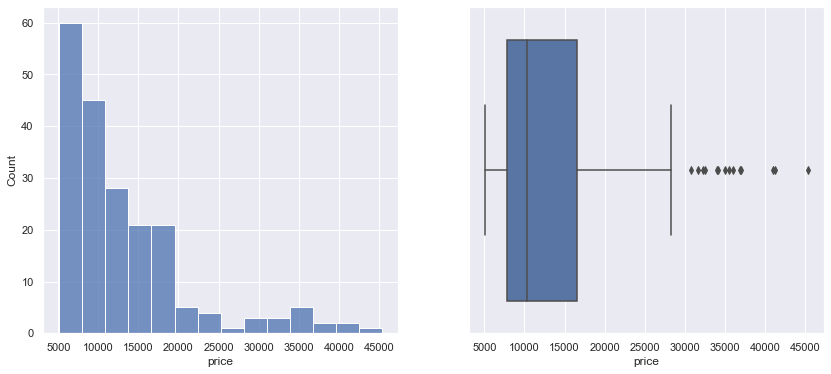

In [22]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(df.price)

plt.subplot(1,2,2)
sns.boxplot(df.price)

plt.show()

I create a normalized dataframe in order to better understand the correlation between different features. In this context with "normalized" I mean to scale the values between 0 and 1:

In [23]:
df_normalized = pd.DataFrame()
for col in df.columns.values:
    if col != 'price': #excluding the labels
        if df[col].dtype != np.object:
            df_normalized[col] = df[col]/df[col].max() #scale between 0 and 1

The histograms show that most of the features aren't following a normal distribution. I will need to work to correct the skewness of the selected features during feature engineering.

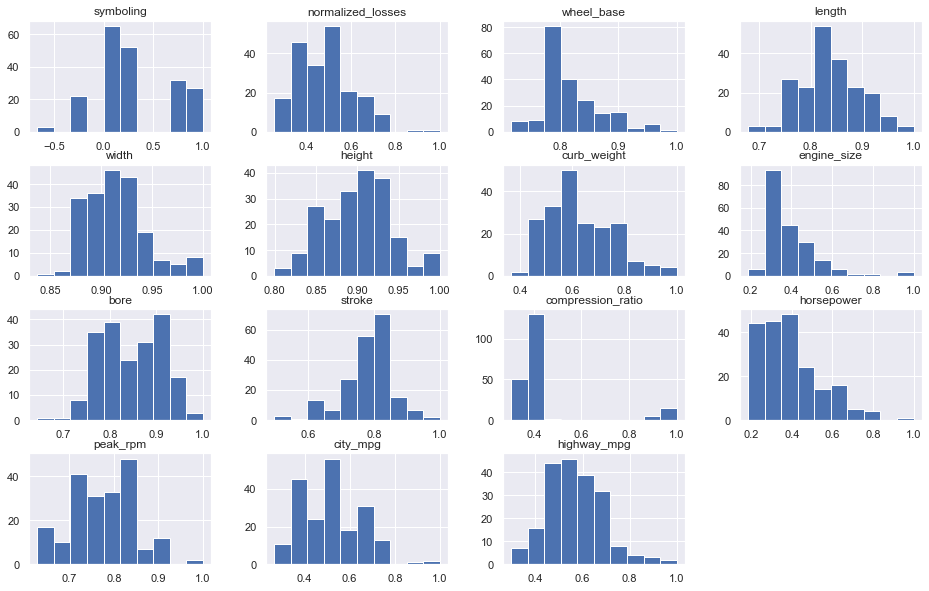

In [24]:
df_normalized.hist(figsize=(16,10))
plt.show()

The boxplots of the nromalized features show that some can potentially be a good predictor, while others have outliers:

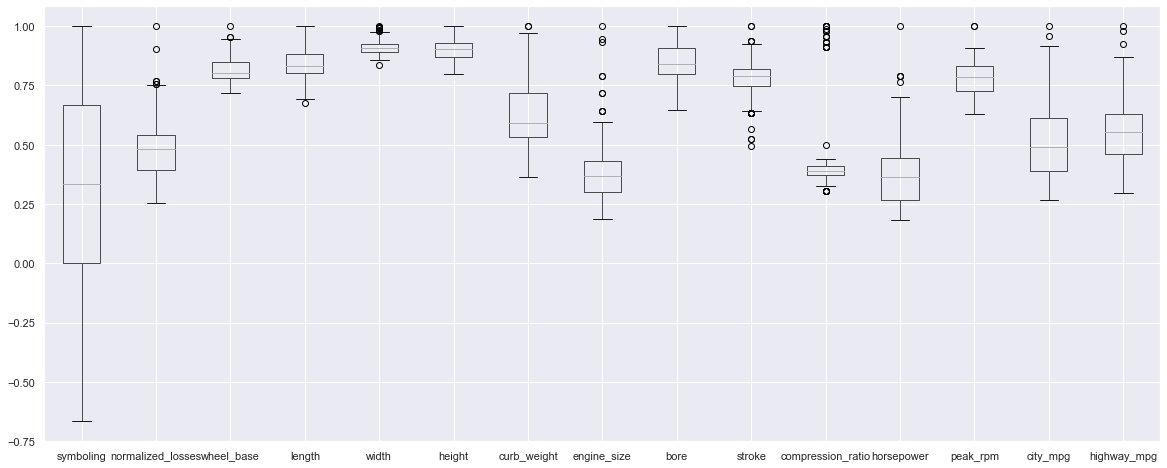

In [25]:
df_normalized.boxplot(figsize=(20,8))
plt.show()

Find the correlation between features having in mind that correlated features can be reduced:

In [26]:
df_normalized.corr()

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
symboling,1.00,0.46,-0.54,-0.37,-0.24,-0.55,-0.23,-0.11,-0.13,-0.00,-0.18,0.08,0.28,-0.04,0.04
normalized_losses,0.46,1.00,-0.01,0.07,0.14,-0.36,0.16,0.19,0.02,0.05,-0.11,0.29,0.23,-0.27,-0.23
wheel_base,-0.54,-0.01,1.00,0.88,0.81,0.59,0.78,0.57,0.49,0.16,0.25,0.37,-0.36,-0.47,-0.54
length,-0.37,0.07,0.88,1.00,0.86,0.49,0.88,0.69,0.60,0.12,0.16,0.58,-0.29,-0.67,-0.70
width,-0.24,0.14,0.81,0.86,1.00,0.31,0.87,0.73,0.54,0.19,0.19,0.61,-0.25,-0.63,-0.68
height,-0.55,-0.36,0.59,0.49,0.31,1.00,0.31,0.07,0.17,-0.06,0.26,-0.09,-0.31,-0.05,-0.10
curb_weight,-0.23,0.16,0.78,0.88,0.87,0.31,1.00,0.85,0.64,0.17,0.16,0.76,-0.28,-0.75,-0.79
engine_size,-0.11,0.19,0.57,0.69,0.73,0.07,0.85,1.00,0.56,0.20,0.03,0.82,-0.26,-0.65,-0.68
bore,-0.13,0.02,0.49,0.60,0.54,0.17,0.64,0.56,1.00,-0.05,-0.00,0.57,-0.25,-0.59,-0.60
stroke,-0.00,0.05,0.16,0.12,0.19,-0.06,0.17,0.20,-0.05,1.00,0.19,0.10,-0.06,-0.04,-0.04


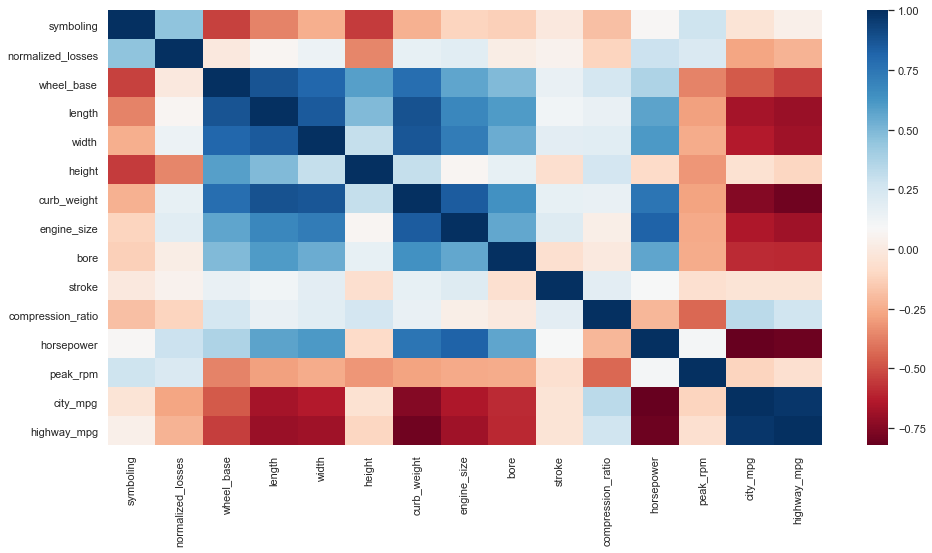

In [27]:
plt.figure(figsize=(16,8))
sns.heatmap(df_normalized.corr(),  cmap='RdBu')
plt.show()

Now looking into the correlation of the features and the price labels to find those which 1) have a Pearson coef which is more than 0.7, and 2) show a p-value < 0.05 (high statistical inference):

In [29]:
results = {}
attributes = []
pearson_coefs = []
p_values = []

for col in df.columns.values:
    if df[col].dtype != np.object: #filter numeric variables
        pearson_coef, p_value = stats.pearsonr(df[col], df.price)
        if (abs(pearson_coef) > 0.7) & (abs(pearson_coef) != 1) & (p_value < 0.05):
            attributes.append(col)
            pearson_coefs.append(pearson_coef)
            p_values.append(p_value)
        
    results['attribute'] = attributes
    results['pearson_coef'] = pearson_coefs
    results['p_value'] = p_values

df_correlated_numeric = pd.DataFrame(results).set_index('attribute')
df_correlated_numeric.style.format('{:e}')

,pearson_coef,p_value
attribute,,
width,7.512653e-01,9.200336e-38
curb_weight,8.344145e-01,2.189577e-53
engine_size,8.723352e-01,9.265492e-64
horsepower,8.102540e-01,4.628887e-48
highway_mpg,-7.046923e-01,1.749547e-31


Note that highway_mpg is negatively correlated to price.

The features with high correlation to the variables are candidate to regression. I am now looking at an overview of the regression plots:

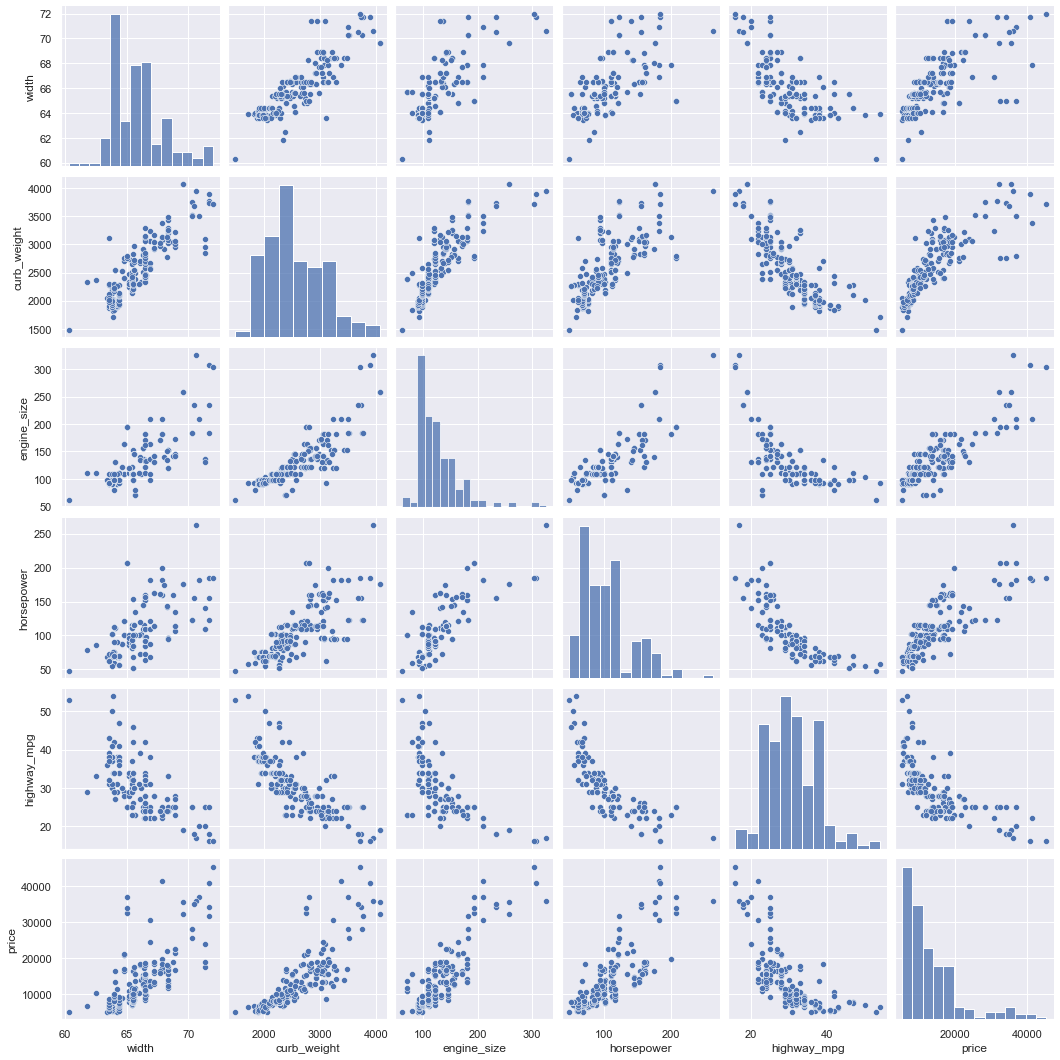

In [30]:
cols = np.append(df_correlated_numeric.index.values, 'price')
sns.pairplot(df[cols]);

In [31]:
df[cols].corr()

,width,curb_weight,engine_size,horsepower,highway_mpg,price
width,1.00,0.87,0.73,0.61,-0.68,0.75
curb_weight,0.87,1.00,0.85,0.76,-0.79,0.83
engine_size,0.73,0.85,1.00,0.82,-0.68,0.87
horsepower,0.61,0.76,0.82,1.00,-0.80,0.81
highway_mpg,-0.68,-0.79,-0.68,-0.80,1.00,-0.70
price,0.75,0.83,0.87,0.81,-0.70,1.00


I now want to verify if the selected numeric features follow a normal distribution. I create a function which helps to check how different transformations affect the distribution of the features:

In [32]:
def normal_test(cols, func, p_val=0.005):
    
    results = {}
    attributes = []
    z_scores = []
    p_values = []
    skews = []

    for col in df[cols]:
        if (p_val==0) | (stats.mstats.normaltest(func(df[col]))[1] > p_val):
            attributes.append(col)
            z_scores.append(stats.mstats.normaltest(func(df[col]))[0])
            p_values.append(stats.mstats.normaltest(func(df[col]))[1])
            skews.append(func(df[col]).skew())

    results['attribute'] = attributes
    results['z_score'] = z_scores
    results['p_value'] = p_values
    results['Skew'] = skews

    df_normal_test = pd.DataFrame(results).set_index('attribute')

    print('Normal distributions using: ', func, '\n')
    
    return df_normal_test.style.format('{:e}')

Just run the function on the data:

In [33]:
normal_test(cols, np.array, 0.005)

Normal distributions using:  <built-in function array> 



,z_score,p_value,Skew
attribute,,,


Try with square root:

In [34]:
normal_test(cols, np.sqrt, 0.005)

Normal distributions using:  <ufunc 'sqrt'> 



,z_score,p_value,Skew
attribute,,,
curb_weight,8.646841e+00,1.325447e-02,4.935269e-01
highway_mpg,1.745870e+00,4.177237e-01,2.062401e-01


Log transformation which returns 3 features that are now perfectly normal:

In [35]:
normal_test(cols, np.log, 0.005)

Normal distributions using:  <ufunc 'log'> 



,z_score,p_value,Skew
attribute,,,
curb_weight,5.974462e+00,5.042688e-02,2.845221e-01
horsepower,7.933798e+00,1.893205e-02,3.913791e-01
highway_mpg,7.911238e-01,6.733016e-01,-1.336165e-01


Just checking the result of the normal test using the log transformation, regardless the features which pass the test:

In [36]:
normal_test(cols, np.log, 0)

Normal distributions using:  <ufunc 'log'> 



,z_score,p_value,Skew
attribute,,,
width,1.979139e+01,5.039126e-05,7.853558e-01
curb_weight,5.974462e+00,5.042688e-02,2.845221e-01
engine_size,2.644098e+01,1.813070e-06,8.668271e-01
horsepower,7.933798e+00,1.893205e-02,3.913791e-01
highway_mpg,7.911238e-01,6.733016e-01,-1.336165e-01
price,1.392082e+01,9.487056e-04,6.786521e-01


Plotting the features with best normal distribution:

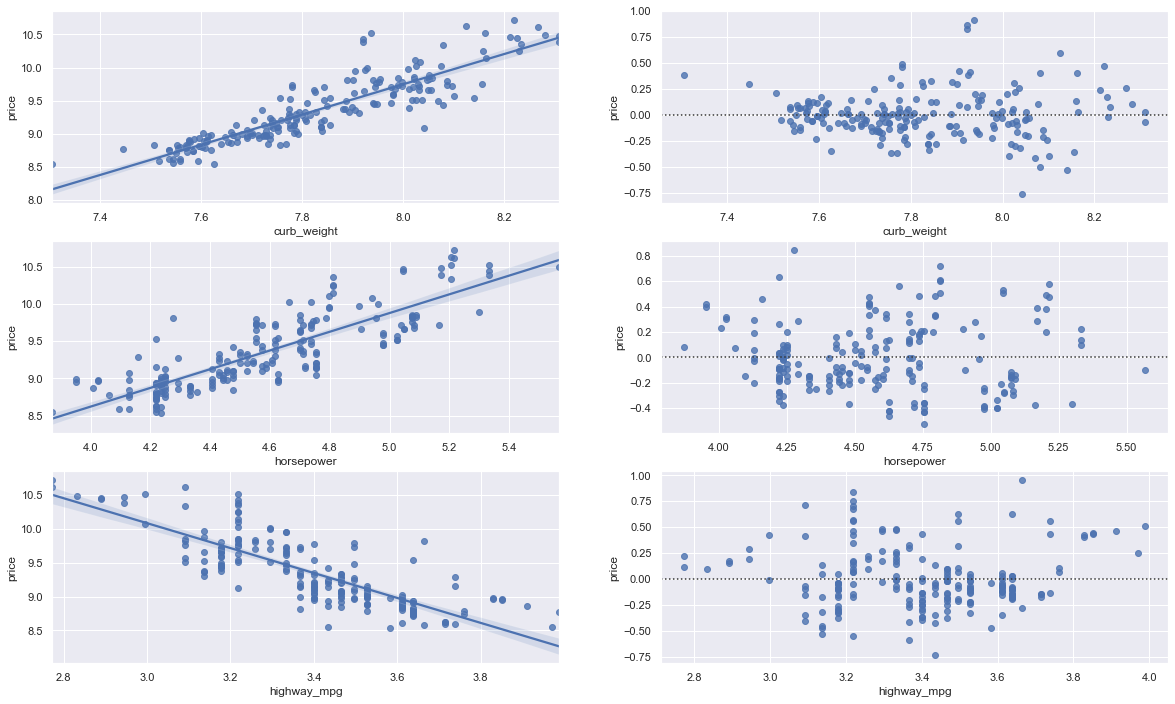

In [37]:
plt.figure(figsize=(20,12))
plt.subplot(3,2,1)
sns.regplot(x=np.log(df.curb_weight), y=np.log(df.price))
plt.subplot(3,2,2)
sns.residplot(x=np.log(df.curb_weight), y=np.log(df.price))
plt.subplot(3,2,3)
sns.regplot(x=np.log(df.horsepower), y=np.log(df.price))
plt.subplot(3,2,4)
sns.residplot(x=np.log(df.horsepower), y=np.log(df.price))
plt.subplot(3,2,5)
sns.regplot(x=np.log(df.highway_mpg), y=np.log(df.price))
plt.subplot(3,2,6)
sns.residplot(x=np.log(df.highway_mpg), y=np.log(df.price))
plt.show()

**Categorical variables**

Start with descriptive statistics:

In [38]:
df.describe(include=np.object).T

,count,unique,top,freq
make,201,22,toyota,32
fuel_type,201,2,gas,181
aspiration,201,2,std,165
num_of_doors,201,2,four,115
body_style,201,5,sedan,94
drive_wheels,201,3,fwd,118
engine_location,201,2,front,198
engine_type,201,6,ohc,145
num_of_cylinders,201,7,four,157
fuel_system,201,8,mpfi,92


Binning one of the numeric features to add it to the basket of the categorical features because it comes with a small range of values:

In [39]:
bins = [-5, 0, 5]

group_names = ['low', 'hig']

df['symboling_binned'] = pd.cut(df.symboling, bins=bins, labels=group_names, include_lowest=True).astype(np.object)

df.symboling_binned.value_counts()

hig    111
low     90
Name: symboling_binned, dtype: int64

I prepare a dataframe with categorical features to ease a further analysis:

In [40]:
df_categorical = pd.DataFrame()
for col in df.columns.values:
    if df[col].dtype == np.object:
        df_categorical[col] = df[col]

df_categorical['price']= df.price #(df.price - df.price.mean())/df.price.std()


Plotting the categorical features to visually check their distribution:

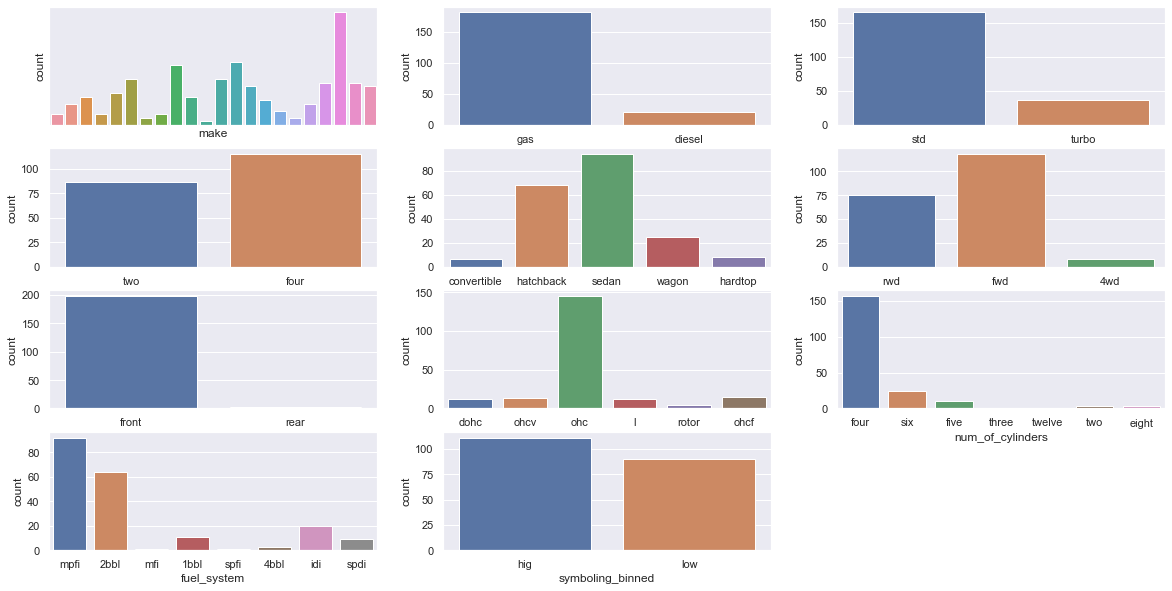

In [41]:
fig = plt.figure(figsize=(20,10))

for col, i in zip(df_categorical.columns.values, range(1,len(df_categorical.columns.values))):
    i = fig.add_subplot(4,3,i)
    sns.countplot(x=col, data=df_categorical, ax=i)
    if col == 'make':
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels('')
        ax.set_yticklabels('')       
        
plt.show()

The boxplots show the same categorical features and their outliers. I can see visually that some have a distinct variation with respect of the price labels:

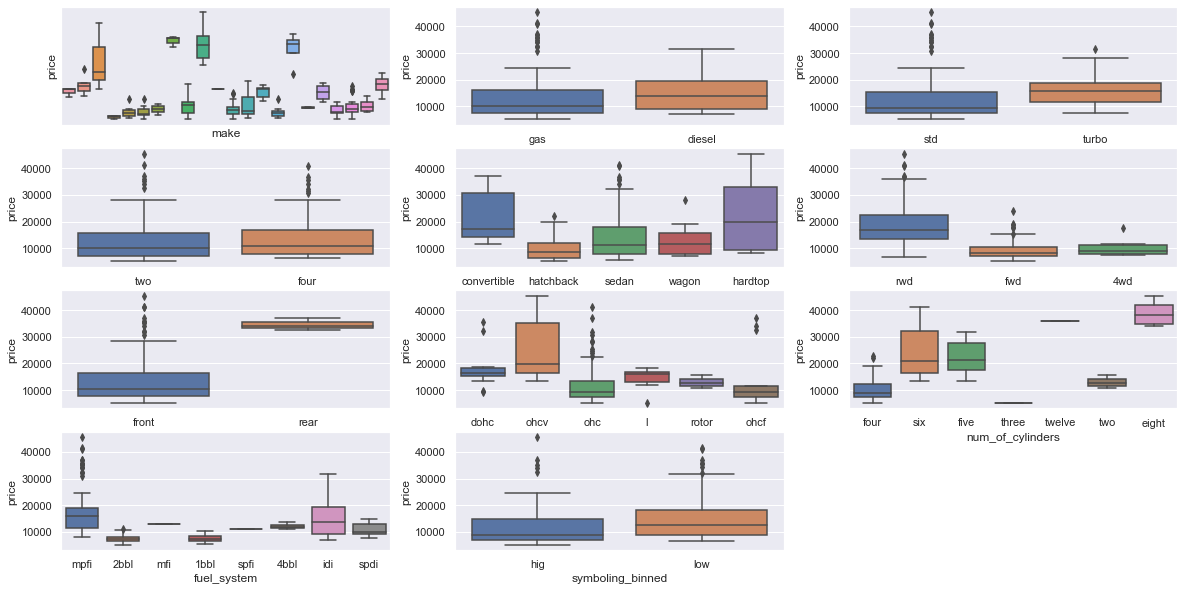

In [42]:
fig = plt.figure(figsize=(20,10))

for col, i in zip(df_categorical.columns.values, range(1,len(df_categorical.columns.values))):
    i = fig.add_subplot(4,3,i)
    sns.boxplot(x=col, y=df_categorical.price, data=df_categorical, ax=i)
    if col == 'make':
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        
plt.show()

Based on the visual representation I have selected 6 categorical features for a better insight into the variance. I will run a F statistics and p-value to show statistical inference with respect of the price labels:

In [43]:
cat = 'body_style'

f_val, p_val = stats.f_oneway(
    df_categorical.groupby(cat).get_group('convertible')['price'],
    df_categorical.groupby(cat).get_group('hatchback')['price'],
    df_categorical.groupby(cat).get_group('sedan')['price'],
    df_categorical.groupby(cat).get_group('wagon')['price'],
    df_categorical.groupby(cat).get_group('hardtop')['price']
    )
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 9.12875185470821 , P = 8.779795237614595e-07


In [44]:
cat = 'drive_wheels'

f_val, p_val = stats.f_oneway(
    df_categorical.groupby(cat).get_group('fwd')['price'],
    df_categorical.groupby(cat).get_group('rwd')['price'],
    df_categorical.groupby(cat).get_group('4wd')['price']
    )
print( "ANOVA results: F=", f_val, ", P =", p_val) 

ANOVA results: F= 67.95406500780399 , P = 3.3945443577151245e-23


In [45]:
cat = 'engine_location'

f_val, p_val = stats.f_oneway(
    df_categorical.groupby(cat).get_group('front')['price'],
    df_categorical.groupby(cat).get_group('rear')['price']
    )
print( "ANOVA results: F=", f_val, ", P =", p_val) 

ANOVA results: F= 24.495550318865693 , P = 1.583490019777699e-06


In [46]:
cat = 'engine_type'

f_val, p_val = stats.f_oneway(
    df_categorical.groupby(cat).get_group('ohc')['price'],
    df_categorical.groupby(cat).get_group('ohcf')['price'],
    df_categorical.groupby(cat).get_group('ohcv')['price'],
    df_categorical.groupby(cat).get_group('l')['price'],
    df_categorical.groupby(cat).get_group('dohc')['price'],
    df_categorical.groupby(cat).get_group('rotor')['price']
    )
print( "ANOVA results: F=", f_val, ", P =", p_val) 

ANOVA results: F= 9.845110955850453 , P = 2.0865492749735665e-08


In [47]:
cat = 'num_of_cylinders'

f_val, p_val = stats.f_oneway(
    df_categorical.groupby(cat).get_group('four')['price'],
    df_categorical.groupby(cat).get_group('six')['price'],
    df_categorical.groupby(cat).get_group('five')['price'],
    df_categorical.groupby(cat).get_group('two')['price'],
    df_categorical.groupby(cat).get_group('eight')['price'],
    df_categorical.groupby(cat).get_group('twelve')['price'],
    df_categorical.groupby(cat).get_group('three')['price']
    )
print( "ANOVA results: F=", f_val, ", P =", p_val) 

ANOVA results: F= 54.9436530466324 , P = 2.8701445428124514e-39


In [48]:
cat = 'symboling_binned'

f_val, p_val = stats.f_oneway(
    df_categorical.groupby(cat).get_group('hig')['price'],
    df_categorical.groupby(cat).get_group('low')['price']
    )
print( "ANOVA results: F=", f_val, ", P =", p_val) 

ANOVA results: F= 10.302596065593512 , P = 0.0015487761265999785


Based on the resul of the tests I pick up the drive wheels and number of cylinders as categorical features for regression:

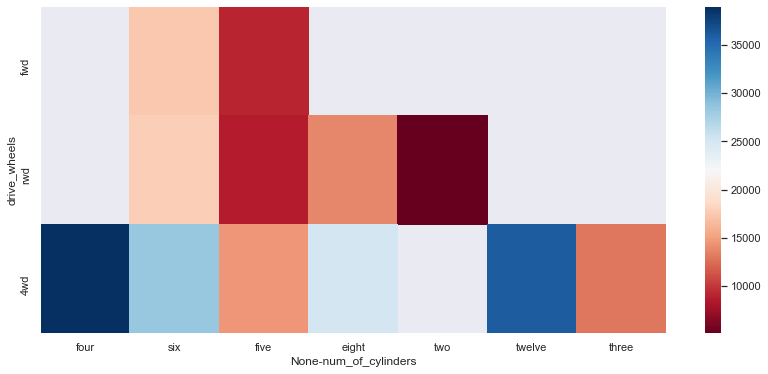

In [49]:
fig = plt.subplots(figsize=(14,6))
sns.heatmap(df_categorical.pivot_table(index='drive_wheels', columns='num_of_cylinders', aggfunc='mean')
            ,  cmap='RdBu'
            , yticklabels=df_categorical.drive_wheels.value_counts().index
            , xticklabels=df_categorical.num_of_cylinders.value_counts().index)
plt.show()

**Feature engineering**

I now need to bring to a nromal distribution the numeric features and the labels using the log function which I selected before. I also need to One Hot Encode the categorical features:

In [50]:
X = pd.concat([np.log(df[['curb_weight', 'horsepower', 'highway_mpg']])
               , pd.get_dummies(df[['num_of_cylinders', 'drive_wheels']])
                ], axis=1)

In [51]:
y = np.log(df.price)

At this stage I decide that no further engineering is necessary in terms of balance of the importance or interaction between fetaures. I will apply scaling during the regression.

**Regression**

Starting with a train-test split:

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

I create a function which will help me run a regression and return a metric, the predictions, and the coefficients:

In [53]:
def make_regression (X_train, X_test, y_train, y_test):

    lr = LinearRegression()

    error_df = list()

    lr = lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)

    error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                               'test' : mean_squared_error(y_test,  y_test_pred)},
                               name='mse'))

    error_df.append(pd.Series({'train': r2_score(y_train, y_train_pred),
                               'test' : r2_score(y_test,  y_test_pred)},
                               name='r2 score'))


    error_df = pd.concat(error_df, axis=1)
    
    return error_df, y_test_pred, lr.coef_

I apply scaling of the features and I run the first round with a simple linear regression:

In [54]:
s = StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)
err, y_pred, coef = make_regression(X_train_s, X_test_s, y_train, y_test)

The r2 score is promising:

In [55]:
err.style.format('{:.4f}')

,mse,r2 score
train,0.0266,0.8762
test,0.0389,0.8833


In [56]:
coef

array([ 0.258039  ,  0.15515854,  0.04819499,  0.05578081,  0.04579356,
       -0.04347272,  0.00066282,  0.00729849,  0.00479444,  0.00559987,
       -0.02334616, -0.01896939,  0.02899935])

I create a function which will help me plotting the distribution of the predictions with respect of the labels. To run this I need to bring back the transformed log labels to the original values:

In [57]:
def plot_distribution(y, pred):
    
    y_test_reversed = np.exp(y)
    y_pred_reversed = np.exp(pred)

    plt.figure(figsize=(16, 8))

    ax = sns.distplot(y_test_reversed, hist=False, color="r", label="Actual Value")
    ax = sns.distplot(y_pred_reversed, hist=False, color="b", label="Fitted Values")
    plt.legend()
    
    plt.show()
    
    pass

Plotting shows that the predictions divert in the range of prices which are above $20K:

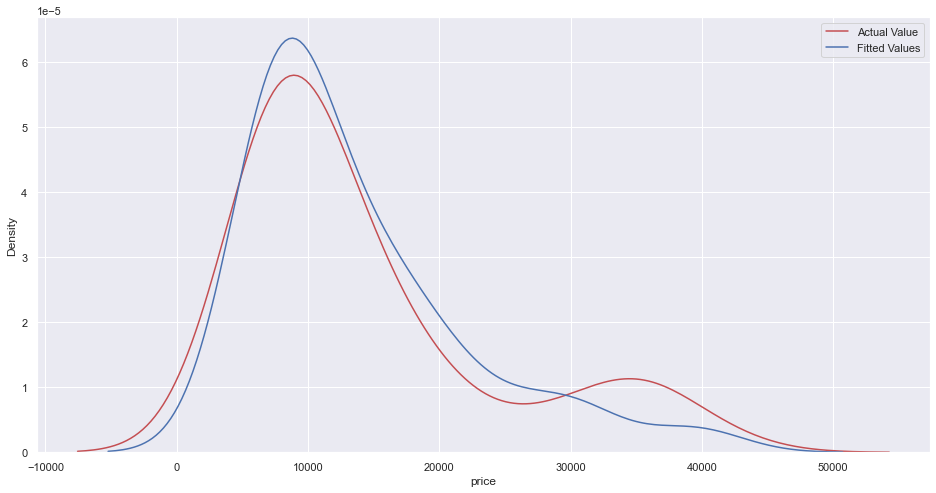

In [58]:
plot_distribution(y_test, y_pred)

I now want to implement cross validation:

In [59]:
lr = LinearRegression()

estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

kf = KFold(shuffle=True, random_state=72018, n_splits=5)

In [60]:
score_arr = cross_val_score(estimator, X, y, cv=kf, scoring='r2')
print('r2 score','min :', score_arr.min(), 'max :', score_arr.max())

r2 score min : 0.7366135010497615 max : 0.9001607342210072


The result is not as good as before:

r2 score: 0.8659


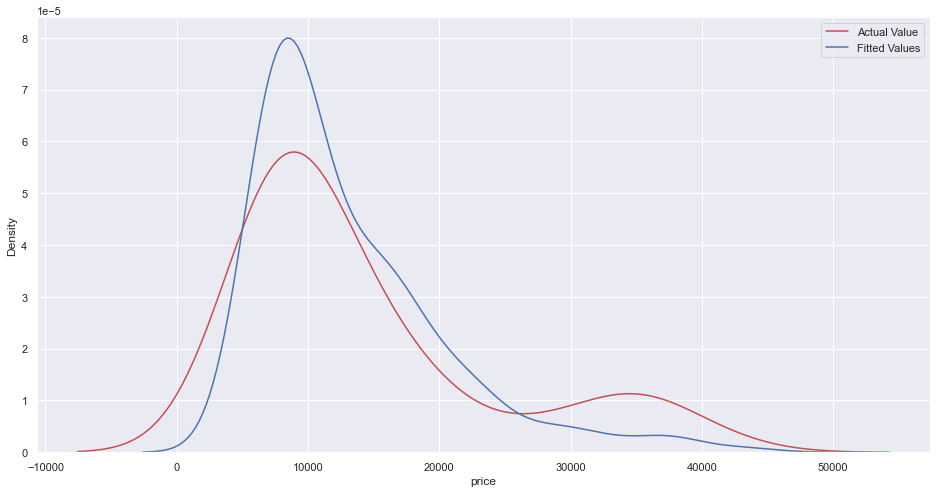

In [61]:
predictions = cross_val_predict(estimator, X, y, cv=kf)
print('r2 score: {:.4f}'.format(r2_score(y, predictions)))
plot_distribution(y_test, predictions)

**Polynomia transformation**

Introducing a polynomial transformation to understand what impact comes from here:

In [62]:
pf = PolynomialFeatures(degree=2)

estimator = Pipeline([
    ("scaler", s),
    ("make_higher_degree", pf),
    ("linear_regression", lr)])

In [63]:
score_arr = cross_val_score(estimator, X, y, cv=kf, scoring='r2')
print('r2 score','min :', score_arr.min(), 'max :', score_arr.max())

r2 score min : -1.8654091593168162e+22 max : 0.8409767829416567


The polynomial transformation is bringing my predictions to quite overfit the labels:

-4.4456256275549426e+21


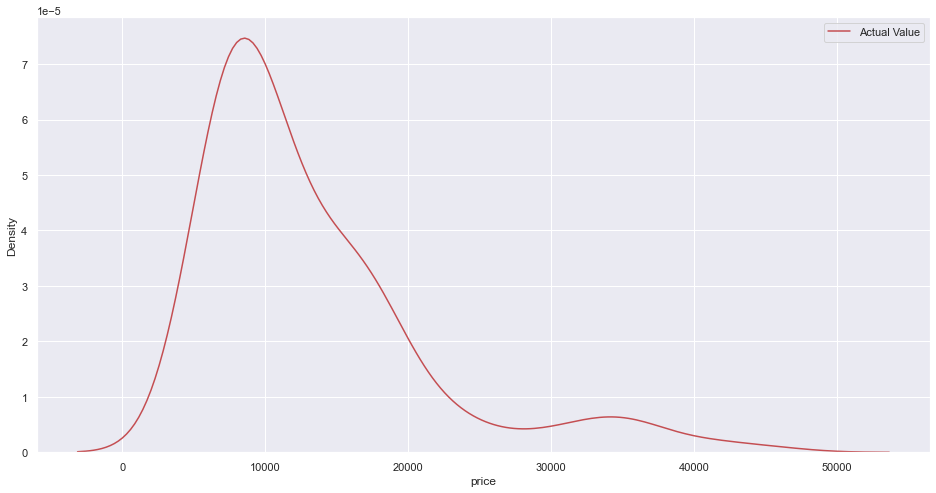

In [64]:
predictions = cross_val_predict(estimator, X, y, cv=kf)
print(r2_score(y, predictions))
plot_distribution(y, predictions)

The boxplot shows that the polynomial transformation introduced extreme outliers:

min:  -257704967789.54834 max:  348687947670.21094


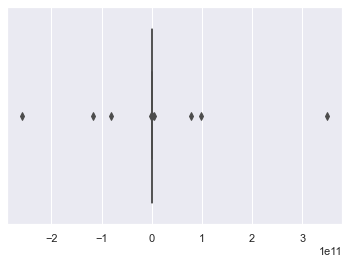

In [65]:
print('min: ', predictions.min(), 'max: ', predictions.max())
sns.boxplot(predictions)
plt.show()

When I remove the outliers the transformation brings in visually more realistic predictions:

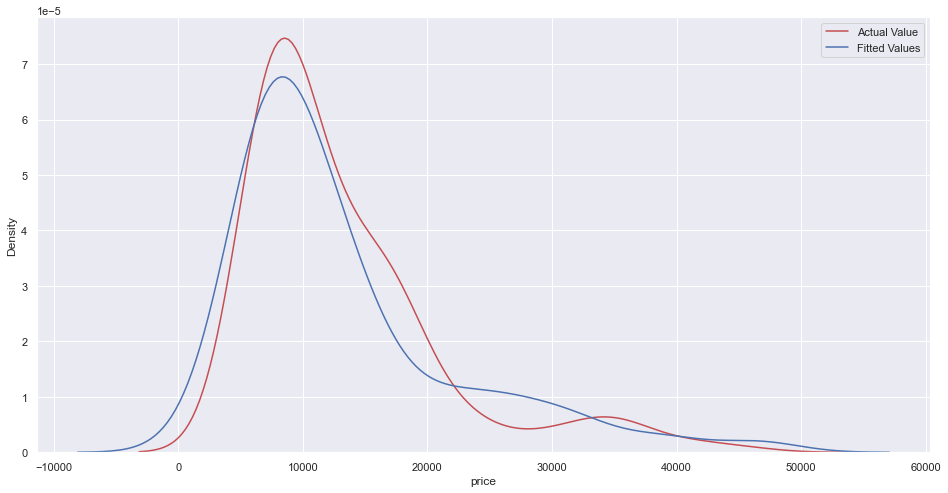

In [66]:
plot_distribution(y, predictions[np.logical_and(predictions>0, predictions<15)])

**Regularization**

I create a function which will help me to use different regularization algorithms. It will test different alpha values, i.e. different levels of precision.

In [67]:
def make_regularization(scaler, poly, Ridge_Lasso):
    
    alphas = np.geomspace(0.001, 100, 10)

    scores=[]
    best_score = 0

    for alpha in alphas:
        model = Ridge_Lasso(alpha=alpha, max_iter=100000)

        estimator = Pipeline([
            ("scaler", scaler),
            ("polynomial_features", poly),
            ("ridge_regression", model)])

        score = np.mean(cross_val_score(estimator, X, y, cv=kf, scoring='r2'))
        scores.append(score)
        if score > best_score:
            predictions = cross_val_predict(estimator, X, y, cv = kf)
            best_score = score

    return alphas, scores, predictions

**Ridge regression**

I start to apply to the polynomia transformation a Ridge regression:

In [68]:
alphas, scores, predictions = make_regularization(s, pf, Ridge)
pd.concat([pd.Series(alphas), pd.Series(scores)],axis=1)

,0,1
0,0.00,0.60
1,0.00,0.69
2,0.01,0.73
3,0.05,0.75
4,0.17,0.79
5,0.60,0.82
6,2.15,0.84
7,7.74,0.85
8,27.83,0.85
9,100.00,0.83


I create a function which will help me to plot the scores for different alpha values:

In [70]:
def plot_alpha_scores(alphas, scores):
    
    fig = plt.figure(figsize=(10,6))
    plt.semilogx(alphas, scores, '-o')
    plt.xlabel('$\\alpha$')
    plt.ylabel('$R^2$')
    
    plt.show()
    
    pass

I can now plot the result of the Ridge regression, find the best alpha and understand visually how the prediction looks like with the best regularization. I could fix the bias introduced by the polynomia transformation:

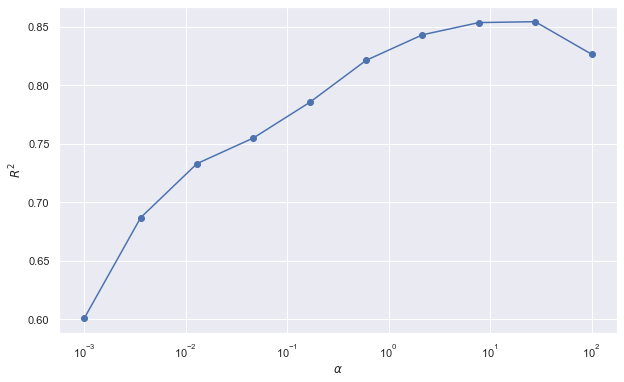

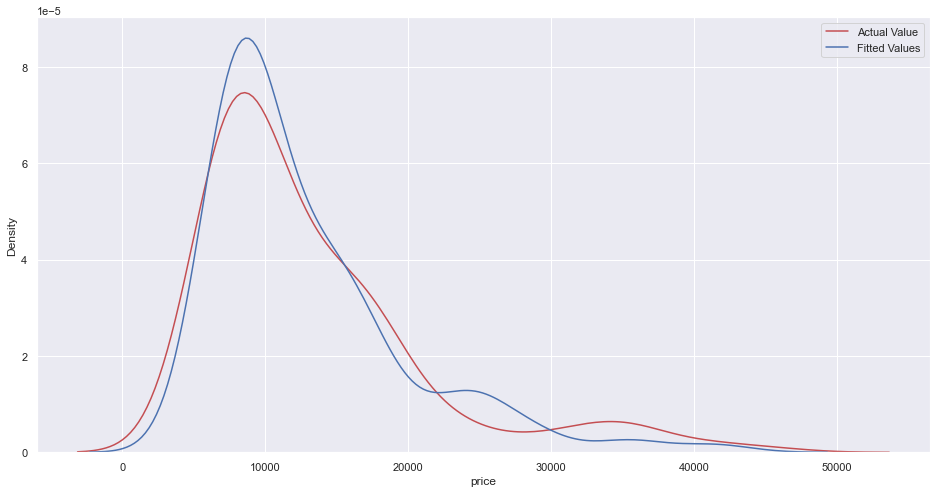

In [71]:
plot_alpha_scores(alphas, scores)

plot_distribution(y, predictions)

Running the Ridge regression with the best estimator brings me a very high score:

In [72]:
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("ridge_regression", Ridge(alpha=0.1))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.9024677183903718

I visualize the coefficients:

In [73]:
best_estimator.named_steps["ridge_regression"].coef_

array([ 0.00000000e+00,  2.27717367e-01,  1.87023978e-01,  1.68593722e-02,
        2.63208243e-03,  3.93769624e-03, -1.76391584e-03, -1.74192068e-03,
       -2.39955260e-04,  3.00591563e-04,  4.73952762e-04, -3.03834821e-04,
       -2.16089314e-02,  2.21215345e-02,  5.24282174e-02, -1.05562767e-01,
        9.88776736e-03, -7.49230941e-02,  1.15469166e-02,  2.81385610e-02,
       -2.91196510e-02, -1.54632454e-02, -1.54038595e-02,  5.67938837e-02,
       -5.69320324e-02,  3.10583581e-02, -8.60606680e-03,  6.20180853e-02,
        1.22230339e-02, -2.76620412e-03,  2.04062413e-01, -4.57441262e-02,
       -5.97717877e-02, -1.27178180e-02, -1.23386413e-02, -2.80901047e-02,
        2.06640936e-02, -2.24571946e-02,  1.45096392e-02,  3.65884620e-02,
       -2.94482313e-02,  1.54781950e-01, -9.12630873e-03, -7.73711626e-02,
       -1.80924198e-03, -1.95887601e-03, -2.96588927e-03, -1.05788698e-02,
       -1.57113902e-02,  2.02708897e-02,  1.80964625e-02, -1.16335679e-03,
       -4.72055914e-03, -

In [74]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(),
                 best_estimator.named_steps["ridge_regression"].coef_,))
df_importances.sort_values(by=1).head(10)

,0,1
15,x0 x1,-0.11
43,x2 x6,-0.08
17,x0 x3,-0.07
32,x1 x6,-0.06
24,x0 x10,-0.06
31,x1 x5,-0.05
82,x6 x11,-0.03
40,x2 x3,-0.03
20,x0 x6,-0.03
35,x1 x9,-0.03


**Hyper parameters tuning using GridsearchCV and Ridge**

In [75]:
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

grid.fit(X, y)

grid.best_score_, grid.best_params_

(0.8561608340530735,
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': 16.932565093713098})

In [76]:
predictions = grid.predict(X)
r2_score(y, predictions)

0.8968634680750325

The result is in line with what I found before:

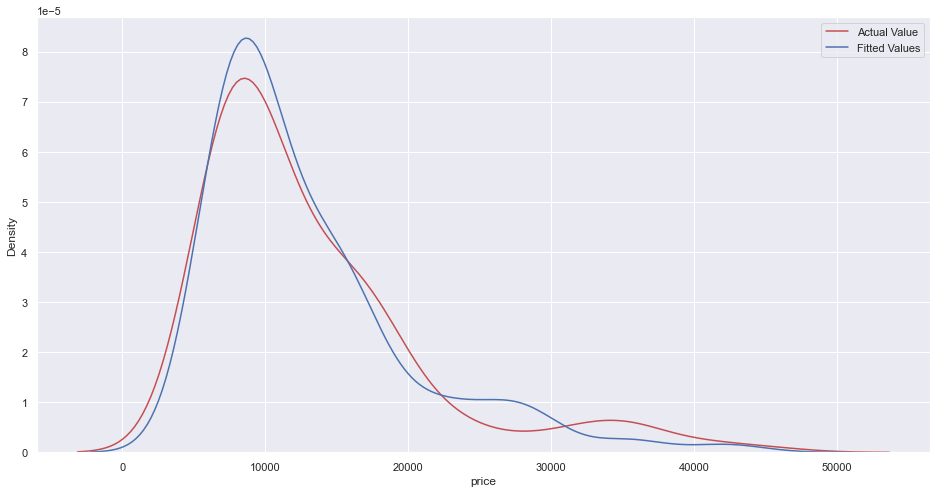

In [77]:
plot_distribution(y, predictions)

I use RidgeCV to run another test, and the result is quite ok:

In [78]:
grid = RidgeCV(alphas = np.geomspace(0.001, 100, 10), cv=kf)

grid.fit(X, y)

predictions = grid.predict(X)

r2_score(y, predictions)

0.8823865144242012

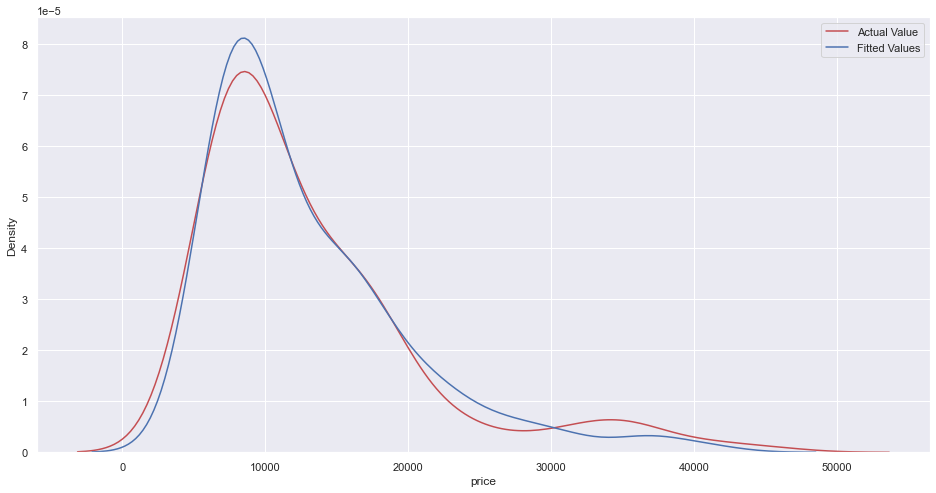

In [79]:
plot_distribution(y, predictions)

**Lasso regression**

In [82]:
alphas, scores, predictions = make_regularization(s, pf, Lasso)
pd.concat([pd.Series(alphas), pd.Series(scores)],axis=1)

,0,1
0,0.00,0.84
1,0.00,0.86
2,0.01,0.86
3,0.05,0.84
4,0.17,0.70
5,0.60,0.06
6,2.15,-0.04
7,7.74,-0.04
8,27.83,-0.04
9,100.00,-0.04


The result of the regularization with Lasso is my best fit:

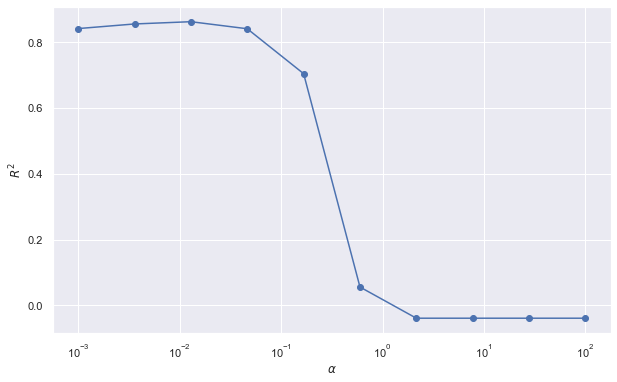

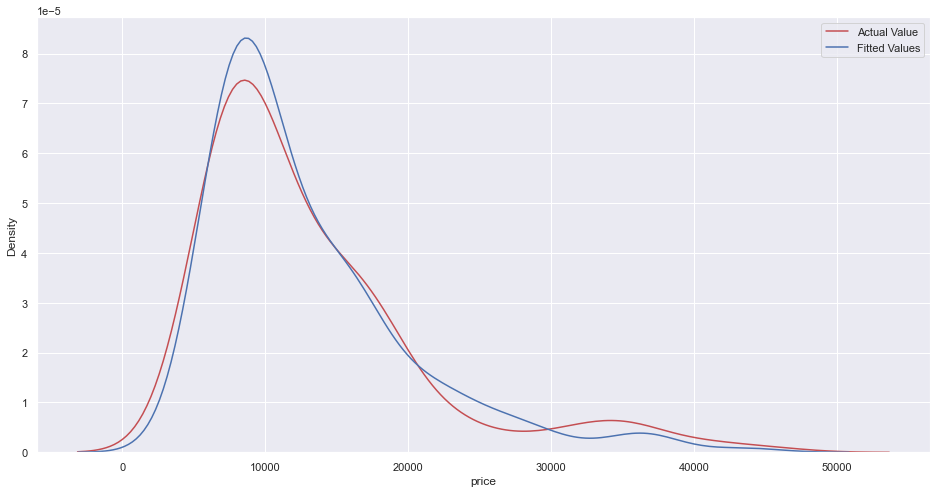

In [83]:
plot_alpha_scores(alphas, scores)

plot_distribution(y, predictions)

In [84]:
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.0001))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.9022986891452188

I can see from the coefs that the Lasso regression has applied a selection of the features:

In [85]:
best_estimator.named_steps["lasso_regression"].coef_

array([ 0.00000000e+00,  2.28366859e-01,  1.76116369e-01,  7.72603669e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -3.89672461e-02,  2.10624152e-02,  4.75829734e-02, -1.06087276e-01,
        7.36048145e-03, -5.56860680e-02,  0.00000000e+00,  0.00000000e+00,
       -4.70581034e-02, -5.02720960e-07,  0.00000000e+00,  0.00000000e+00,
       -5.35391783e-02,  3.45782169e-02, -0.00000000e+00,  5.66389985e-02,
        0.00000000e+00,  6.44832605e-03,  1.72261870e-01,  0.00000000e+00,
       -1.93322793e-02, -5.50729078e-04,  0.00000000e+00, -0.00000000e+00,
        1.44084079e-02, -3.37821709e-02,  0.00000000e+00,  3.10923760e-02,
       -2.63329615e-02,  1.19940701e-01,  0.00000000e+00, -6.26699147e-02,
        6.52795035e-04, -0.00000000e+00, -0.00000000e+00, -4.84614082e-03,
       -0.00000000e+00,  3.47920033e-02,  1.36878163e-02, -0.00000000e+00,
       -0.00000000e+00,  

In [86]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(),
                 best_estimator.named_steps["lasso_regression"].coef_,))
df_importances.sort_values(by=1).tail(10)

,0,1
13,x12,0.02
39,x2^2,0.03
25,x0 x11,0.03
49,x2 x12,0.03
14,x0^2,0.05
27,x1^2,0.06
41,x2 x4,0.12
30,x1 x4,0.17
2,x1,0.18
1,x0,0.23


I use LassoCV to run another test, and the result is quite ok:

In [87]:
grid = LassoCV(alphas = np.geomspace(0.001, 100, 10), cv=kf)

grid.fit(X, y)

predictions = grid.predict(X)

r2_score(y, predictions)

0.8805216105071667

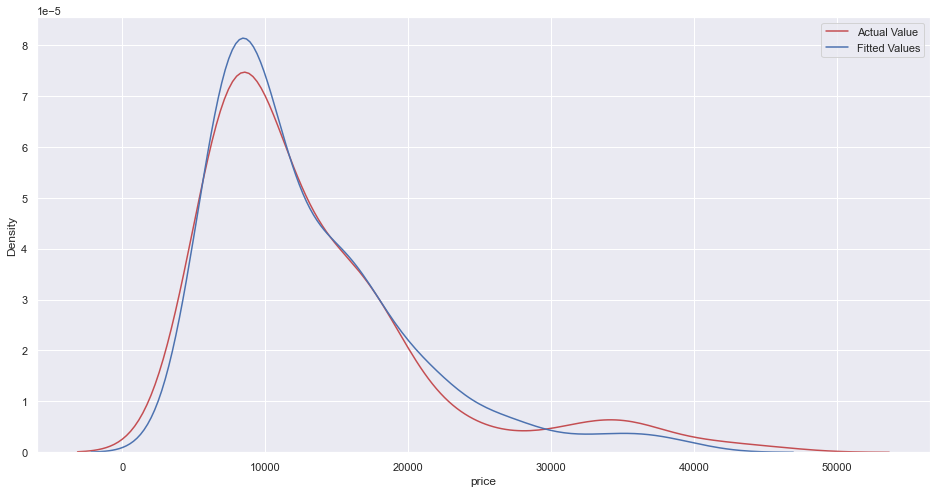

In [88]:
plot_distribution(y, predictions)